Simulating Saturation
===========================

![](p_control_with_sat.png)
*Block diagram representing saturation in a feedback control system*

This notebook gives two options for simulating s feedback control system that includes saturation, like the one shown above.  The first option is to use the `python-control` module and specifically `control.forced_response` inside of a `for` loop.  The main advantage of this method is that it still allows the user to think in terms of transfer functions.  Using `control.forced_response` can be a little slow for plants with pure integrators.  The second option is to fall back to numeric integration (Runge-Kutta) using `scipy.intergrate.odeint`.  This approach can be very fast and can handle arbitrary nonlinearities, but it requires programming differential equations rather than using transfer functions.

The first step under the first option is simulating the affects of saturation on a closed-loop system is simulating the system one time step at a time so that the code can limit the input to the plant transfer function.  The key challenge in simulating the response one step at a time is that the initial conditions to `control.forced_response` need to be the ending conditions from the previous time step.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control

Consider a plant under proportional control:

In [2]:
p = 6
g = 5
G = control.TransferFunction(g*p,[1,p,0])

## Simple Simulation Ignoring Saturation

If we just wanted to simulate the closed-loop response without concern for saturation, we could do the following:

In [3]:
kp = 5
cltf = control.feedback(kp*G)

In [4]:
cltf


      150
---------------
s^2 + 6 s + 150

(0, 1050)

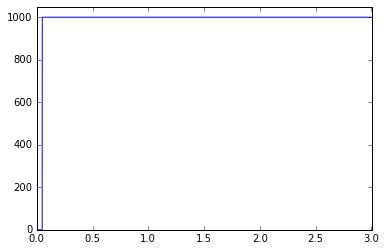

In [5]:
t = np.arange(0,3,0.001)
amp = 1000
u = np.zeros(len(t))
u[50:] = amp
plt.figure()
plt.plot(t,u)
plt.ylim([0,1050])

In [6]:
t, y_fb, x = control.forced_response(cltf, t, u)

In [7]:
y_fb.shape

(3000,)

In [8]:
x.shape

(2, 3000)

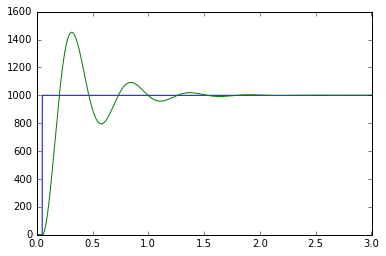

In [9]:
plt.figure()
plt.plot(t,u,t,y_fb)

## One Step at a Time Simulation

In [10]:
n = len(G.pole())
x_prev = np.zeros(n)
y_one_step = np.zeros(len(t))
dt = t[1]-t[0]
pwm_vect = np.zeros(len(t))

import pdb

for i, t_i in enumerate(t):
    e = u[i] - y_one_step[i-1]
    pwm = kp*e
    pwm_vect[i] = pwm
    t_temp, y_temp, x_temp = control.forced_response(G,[t_i-dt,t_i],[pwm,pwm], X0=x_prev)
    y_one_step[i] = np.squeeze(y_temp[-1])
    x_prev = np.squeeze(x_temp[:,-1])

In [11]:
x_temp

array([[ -3.16497465e-02,  -3.22616017e-02],
       [  3.33386906e+01,   3.33386587e+01]])

In [12]:
y_one_step

array([    0.        ,     0.        ,     0.        , ...,  1000.16165841,
        1000.16071821,  1000.15975953])

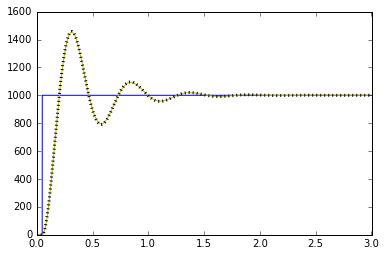

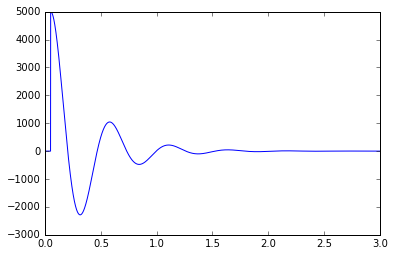

In [13]:
plt.figure()
plt.plot(t,u,t,y_fb,'y')
plt.plot(t, y_one_step,'k:',linewidth=3)

plt.figure()
plt.plot(t,pwm_vect)

In [14]:
G.pole()

array([-6.,  0.])

## Saturation Control Function

In [15]:
def P_control_sat_sim(G, Kp, t, u, pos_sat=255, neg_sat=-255):
    def mysat(pwmin):
        if pwmin > pos_sat:
            pwmout = pos_sat
        elif pwmin < neg_sat:
            pwmout = neg_sat
        else:
            pwmout = pwmin
        return pwmout
    
    n = len(G.pole())
    x_prev = np.zeros(n)
    y_one_step = np.zeros(len(t))
    dt = t[1]-t[0]
    pwm_vect = np.zeros(len(t))

    for i, t_i in enumerate(t):
        e = u[i] - y_one_step[i-1]
        pwm = kp*e
        pwm_star = mysat(pwm)
        pwm_vect[i] = pwm_star
        t_temp, y_temp, x_temp = control.forced_response(G,[t_i-dt,t_i], \
                                                         [pwm_star,pwm_star], X0=x_prev)
        y_one_step[i] = np.squeeze(y_temp[-1])
        x_prev = np.squeeze(x_temp[:,-1])
        
    return y_one_step, pwm_vect

In [16]:
y_sat, pwm_vect = P_control_sat_sim(G,5,t,u)

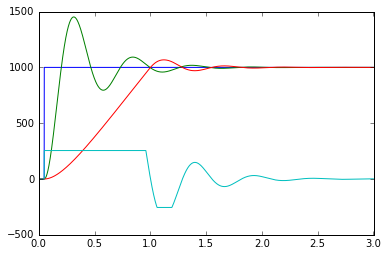

In [17]:
plt.figure()
plt.plot(t,u,t,y_fb,t,y_sat, t, pwm_vect)

In [18]:
mylist = ['a','b','c']

for i, item in enumerate(mylist):
    print('%i: %s' % (i,item))

0: a
1: b
2: c


Differential Equation Approach
=================================

An alternative to using `control.forced_response` inside a `for` loop is to use `integrate.odeint`.  `odeint` avoids transfer functions entirely and works directly on the differential equation.  An advantage of `odeint` is that it can handle fully nonlinear systems.

If the transfer function is 

\begin{equation}
G(s) = \frac{\Theta(s)}{V(s)} = \frac{gp}{s^2+ps}
\end{equation}

then the corresponding differential equation is 

\begin{equation}
\ddot{\theta} + p \dot{\theta} = gp v
\end{equation}

In order to use `odeint`, the differential equation model needs to be rearranged into a series of first order differential equations by defining states:


\begin{align}
x_1 & = \theta \\
x_2 & = \dot{\theta}
\end{align}

Solving for the derivatives of the states gives

\begin{align}
\dot{x}_1 & = x_2 \\
\dot{x}_2 & = gpv - p x_2
\end{align}


In [26]:
def mysat(vin):
    if vin > 255:
        vout = 255
    elif vin < -255:
        vout = -255
    else:
        vout = vin
    return vout

In [32]:
def dxdt(x,t,kp,theta_d,use_sat=True):
    theta = x[0]
    theta_dot = x[1]
    e = theta_d - theta
    v = kp*e
    if use_sat:
        v = mysat(v)
    out = [theta_dot, g*p*v-p*theta_dot]
    return out

In [33]:
from scipy import integrate

In [40]:
x_mat1 = integrate.odeint(dxdt,[0,0],t,args=(5,1000,False))

In [41]:
x_mat2 = integrate.odeint(dxdt,[0,0],t,args=(5,1000,True))

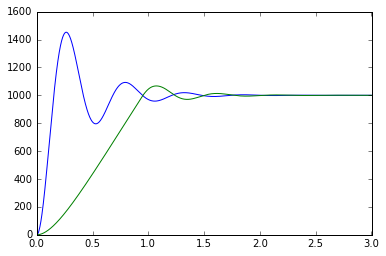

In [42]:
plt.figure()
plt.plot(t,x_mat1[:,0])
plt.plot(t,x_mat2[:,0])